## Project 

In [1]:
import torch 
import numpy as np

np.random.seed(1328)
torch.random.manual_seed(1328)

In [2]:
import os
import cv2
from tqdm import tqdm
import shutil

def capture_frames(video_name, output_folder, num_frames_to_capture=1000):
    # Extract the filename without extension
    video_name_without_extension = os.path.splitext(os.path.basename(video_name))[0]
    video = cv2.VideoCapture(video_name)
    
    # Read a frame to get video information
    ret, _ = video.read()
    if not ret:
        print(f"Error: unable to open the video {video_name}.")
        return 0, 0
    
    # Get the total number of frames in the video
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_captured = 0

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Determine the actual number of frames to capture
    step_size = max(total_frames // num_frames_to_capture, 1)
    tqdm_total = min(num_frames_to_capture, total_frames)
    
    # Initialize the progress bar
    with tqdm(total=tqdm_total, desc=f'Processing {video_name}', unit='frame') as progress_bar:
        for i in range(0, total_frames, step_size):
            video.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = video.read()
            if not ret:
                break
            
            # Frame processing and saving
            frame = cv2.resize(frame, (224, 224))
            frame_path = os.path.join(output_folder, f"frame_{frames_captured + 1}.png")
            cv2.imwrite(frame_path, frame)
            frames_captured += 1
            
            # Update the progress bar
            progress_bar.update(1)  

    print(f"Processing completed for {video_name}.")
    video.release()
    return frames_captured, total_frames


def process_videos_in_folder(folder_path, num_frames_to_capture=1000):
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.mp4'):
            file_path = os.path.join(folder_path, file_name)
            output_folder = os.path.join(os.path.dirname(folder_path), f"{os.path.splitext(file_name)[0]}_frames")
            captured, total = capture_frames(file_path, output_folder, num_frames_to_capture)
            print(f'Extracted {captured}/{total} frames from {file_name}')

In [3]:
def reorganize_frames(data_dir):
    categories = ['rock', 'paper', 'scissors']
    
    for category in categories:
        output_folder = os.path.join(data_dir, f"{category}_frames")
        
        # Collect all frames for each category
        for dir_name in os.listdir(data_dir):
            if dir_name.startswith(category):
                src_folder = os.path.join(data_dir, dir_name)
                for frame_name in os.listdir(src_folder):
                    src_path = os.path.join(src_folder, frame_name)
                    dest_path = os.path.join(output_folder, frame_name)
                    shutil.move(src_path, dest_path)
                    
    print("Reorganization completed.")

In [4]:
data_dir = ['data/train', 'data/test']

# Reorganize frames
for dir_path in data_dir:
    reorganize_frames(dir_path)

Reorganization completed.
Reorganization completed.


In [5]:
import pandas as pd

train_images = []
train_labels = []
test_images = []
test_labels = []

for dir_path in data_dir:    
    for subfolder in os.listdir(dir_path):
        subfolder_path = os.path.join(dir_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue

        if subfolder.endswith('_frames'):
            label = subfolder.replace('_frames', '')
            for image_filename in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_filename)
                if dir_path == 'data/train':
                    train_images.append(image_path)
                    train_labels.append(label)
                else:
                    test_images.append(image_path)
                    test_labels.append(label)

df_train = pd.DataFrame({'image': train_images, 'label': train_labels})
df_test = pd.DataFrame({'image': test_images, 'label': test_labels})

print(f"Training DataFrame Description:\n{df_train.describe()}\nTraining DataFrame:\n{df_train.sample(5)}")
print('-' * 60)
print(f"Testing DataFrame Description:\n{df_test.describe()}\nTesting DataFrame:\n{df_test.sample(5)}\n")

Training DataFrame Description:
                                       image     label
count                                  14616     14616
unique                                 14616         3
top     data/train/rock_frames/frame_201.png  scissors
freq                                       1      5090
Training DataFrame:
                                           image     label
2447       data/train/rock_frames/frame_2734.png      rock
14247  data/train/scissors_frames/frame_2396.png  scissors
11605  data/train/scissors_frames/frame_2277.png  scissors
12524   data/train/scissors_frames/frame_490.png  scissors
5902      data/train/paper_frames/frame_1547.png     paper
------------------------------------------------------------
Testing DataFrame Description:
                                      image label
count                                  1500  1500
unique                                 1500     3
top     data/test/rock_frames/frame_201.png  rock
freq                       

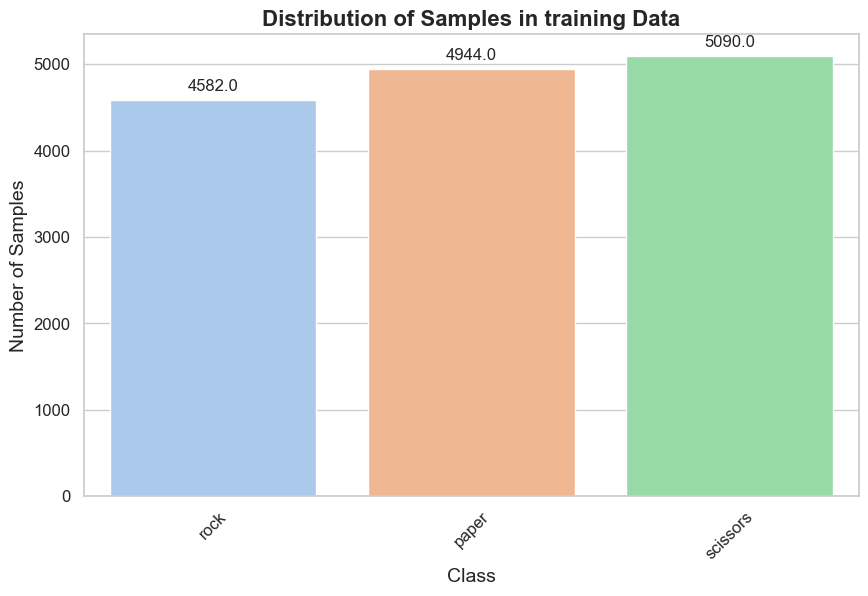

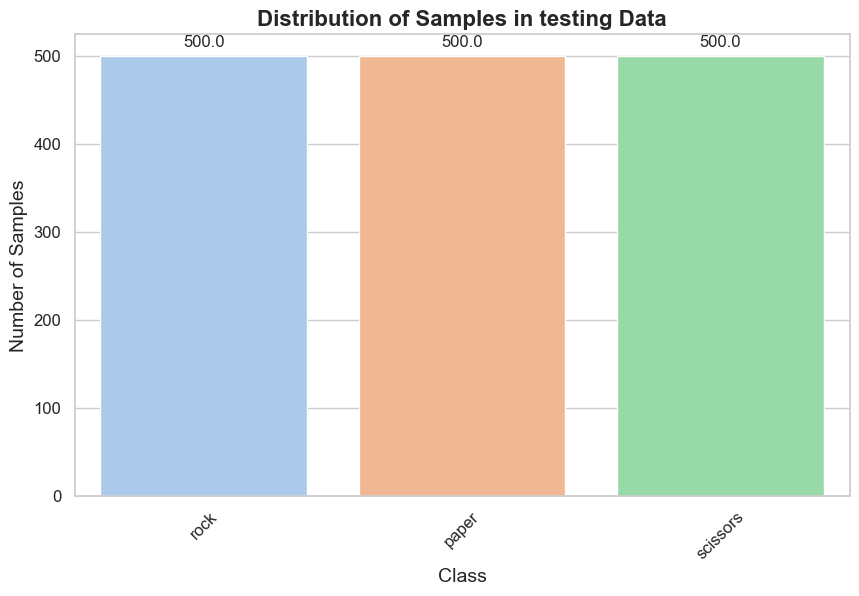

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(df, title):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=df.label, hue=df.label, palette="pastel", dodge=False)
    ax.set_title(f"Distribution of Samples in {title} Data", fontsize=16, fontweight='bold')
    ax.set_xlabel("Class", fontsize=14)
    ax.set_ylabel("Number of Samples", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f'plots/distribution_{title}_data.png')

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)
    plt.show()

plot_class_distribution(df_train, "training")
plot_class_distribution(df_test, "testing")

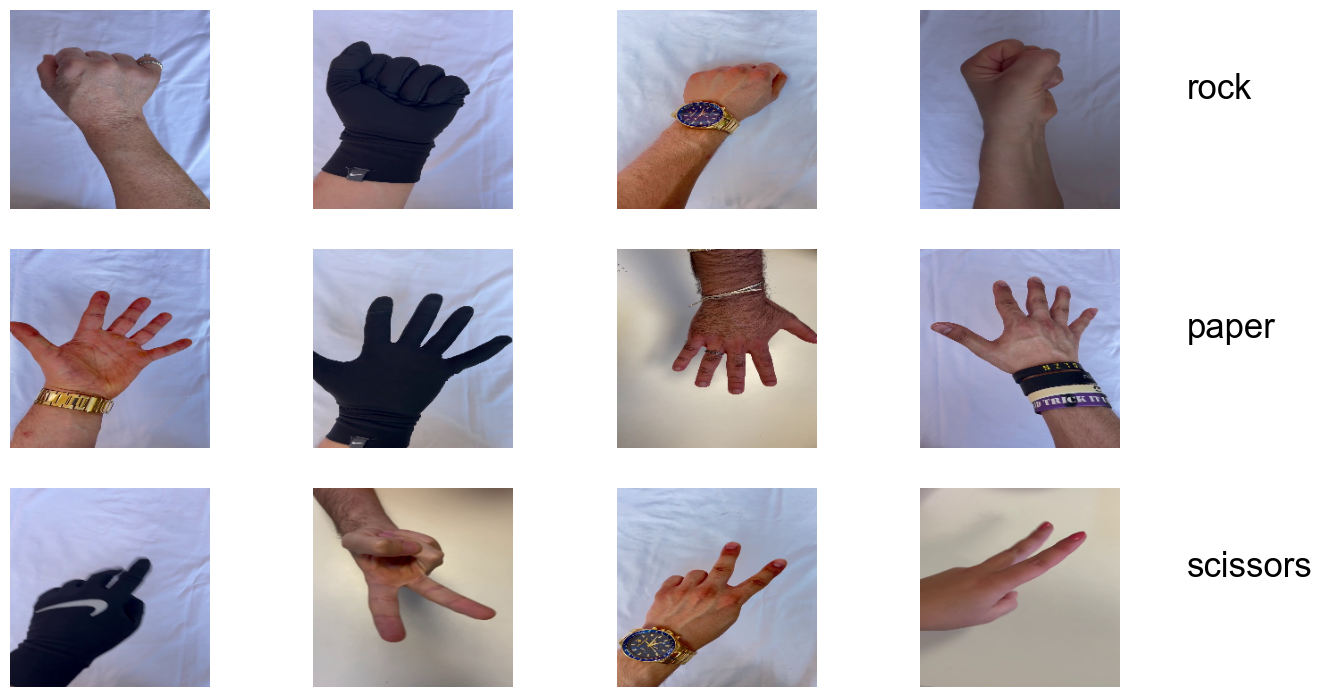

In [7]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 15))
gs = GridSpec(5, 4, figure=fig)

for i, category in enumerate(df_train['label'].unique()):
    filepaths = df_train[df_train['label'] == category]['image'].values[:4]
    for j, filepath in enumerate(filepaths):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(plt.imread(filepath))
        ax.axis('off')
    ax.text(300, 100, category, fontsize=25, color='black')
plt.show()

In [8]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, augment=False):
        self.transform = transform
        self.augment = augment
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(dataframe['label'].unique())}
        if self.augment:
            self.dataframe = pd.concat([dataframe, dataframe]).reset_index(drop=True)
        else:
            self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row.iloc[0]
        image = Image.open(img_name)
        label_str = row.iloc[1]
        label = self.class_to_idx[label_str]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop((50, 50)), 
    transforms.RandomAffine(30),  
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_df, test_df = train_test_split(df_test, test_size=0.2, random_state=42)

# Create datasets
train_dataset = CustomDataset(df_train, transform=train_transform, augment=True)
val_dataset = CustomDataset(val_df, transform=val_transform)
test_dataset = CustomDataset(df_test, transform=val_transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset: {len(val_dataset)} samples")
print(f"Testing Dataset: {len(test_dataset)} samples")
print("-" * 40)
print(f"Total samples: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")

Training Dataset: 29232 samples
Validation Dataset: 1200 samples
Testing Dataset: 1500 samples
----------------------------------------
Total samples: 31932


Training Samples (29232)


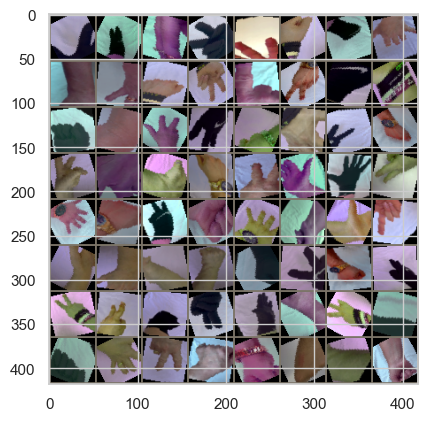

Validation Samples (1200)


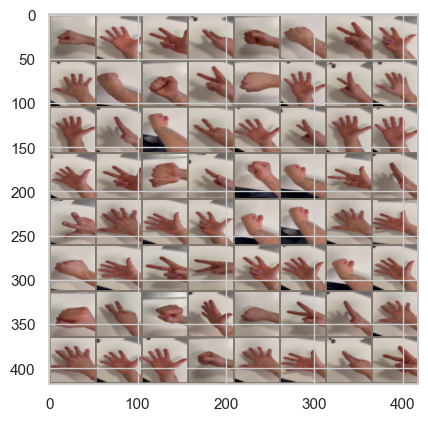

Testing Samples (1500)


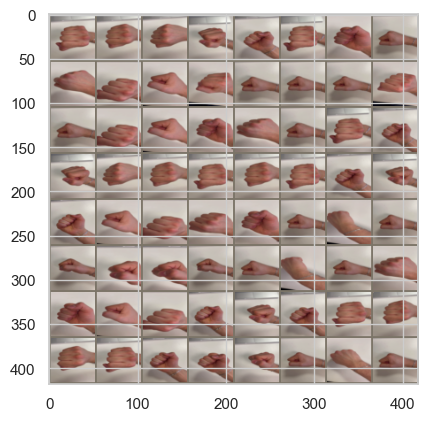

In [9]:
import numpy as np
import torchvision

def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

# Training data
print(f"Training Samples ({len(train_dataset)})")
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)
imshow(out)

# Validation data
print(f"Validation Samples ({len(val_dataset)})")
inputs, classes = next(iter(val_loader))
out = torchvision.utils.make_grid(inputs)
imshow(out)

# Testing data
print(f"Testing Samples ({len(test_dataset)})")
inputs, classes = next(iter(test_loader))
out = torchvision.utils.make_grid(inputs)
imshow(out)

In [10]:
class AverageValueMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.sum = 0
        self.n = 0

    def add(self, value, n):
        self.sum += value * n
        self.n += n

    def value(self):
        return self.sum / self.n if self.n > 0 else 0

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from os.path import join
import pickle

class RPSClassifier(nn.Module):
    
    def __init__(self, input_shape=(50, 50, 3), num_classes=3, dropout_rate=0.5):
        super(RPSClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # convolutional layer 1
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # convolutional layer 2
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # convolutional layer 3
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # convolutional layer 4
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 512), # fully connected layer
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(512, num_classes) # output layer (fully connected)
        )

    def forward(self, x):
        return self.model(x)

    def numparams(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

        #optimizer = optim.AdamW(self.model.parameters(), lr, weight_decay=weight_decay)

    def train_model(self, train_loader, val_loader, exp_name='experiment', epochs=10, lr=0.001, momentum=0.9, weight_decay=1e-4, logdir='logs', verbose=True, save_model=True):
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr, momentum=momentum, weight_decay=weight_decay)  

        train_losses = []; train_accuracies = []
        val_losses = []; val_accuracies = []

        loss_meter = AverageValueMeter()
        acc_meter = AverageValueMeter()
        writer = SummaryWriter(join(logdir, exp_name))

        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.to(device)
        loader = {'train': train_loader, 'val': val_loader}

        global_step = 0
        best_val_loss = float('inf')
        epochs_no_improve = 0  
        patience = 10
        for e in range(epochs):
            print(f'[Epoch {e+1}/{epochs}]')
            for mode in ['train', 'val']:
                loss_meter.reset()
                acc_meter.reset()
                self.model.train() if mode == 'train' else self.model.eval()

                with torch.set_grad_enabled(mode == 'train'):
                    for i, batch in enumerate(loader[mode]):
                        X = batch[0].to(device)
                        y = batch[1].to(device)
                        out = self.model(X)

                        n = X.shape[0]
                        global_step += n
                        l = loss_fn(out, y)

                        if mode == 'train':
                            l.backward()
                            optimizer.step()
                            optimizer.zero_grad()

                        loss_meter.add(l.item(), n)
                        acc = accuracy_score(y.to('cpu'), out.to('cpu').max(1)[1])
                        acc_meter.add(acc, n)

                        if mode == 'train':
                            writer.add_scalar('loss/train', loss_meter.value(), global_step=global_step)
                            writer.add_scalar('accuracy/train', acc_meter.value(), global_step=global_step)

                    writer.add_scalar('loss/'+mode, loss_meter.value(), global_step=global_step)
                    writer.add_scalar('accuracy/'+mode, acc_meter.value(), global_step=global_step)

                    if mode == 'train':
                        train_losses.append(loss_meter.value())
                        train_accuracies.append(acc_meter.value())
                    else:
                        val_losses.append(loss_meter.value())
                        val_accuracies.append(acc_meter.value())

                        if val_losses[-1] < best_val_loss:
                            best_val_loss = val_losses[-1]
                            epochs_no_improve = 0  
                            if save_model:
                                torch.save(self.model.state_dict(), os.path.join('models', f'{exp_name}.pth'))
                                with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'wb') as f:
                                    pickle.dump({
                                        'train_loss': train_losses, 
                                        'val_loss': val_losses,
                                        'train_accuracy': train_accuracies, 
                                        'val_accuracy': val_accuracies
                                    }, f)
                        else:
                            epochs_no_improve += 1 

            if verbose:
                print(f'Train Loss: {train_losses[-1]:.3f}, Train Accuracy: {train_accuracies[-1]:.3f} | Val Loss: {val_losses[-1]:.3f}, Val Accuracy: {val_accuracies[-1]:.3f}\n')

            if epochs_no_improve == patience:
                print('Early stopping')
                break

        return train_losses, train_accuracies, val_losses, val_accuracies

    def test_model(self, test_loader):
        self.model.eval()
        loss_fn = nn.CrossEntropyLoss()
        loss_meter = AverageValueMeter()
        acc_meter = AverageValueMeter()
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.to(device)

        with torch.no_grad():
            for batch in test_loader:
                X = batch[0].to(device)
                y = batch[1].to(device)
                out = self.model(X)

                n = X.shape[0]
                l = loss_fn(out, y)

                loss_meter.add(l.item(), n)
                acc = accuracy_score(y.to('cpu'), out.to('cpu').max(1)[1])
                acc_meter.add(acc, n)

        test_loss = loss_meter.value()
        test_accuracy = acc_meter.value()

        return test_loss, test_accuracy

    def test_error(self, test_loader):
        device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.model.to(device)
        predictions, labels = [], []
        with torch.no_grad():
            for batch in test_loader:
                x = batch[0].to(device)
                y = batch[1].to(device)
                output = self.model(x)
                preds = output.to('cpu').max(1)[1].numpy()
                labs = y.to('cpu').numpy()
                predictions.extend(list(preds))
                labels.extend(list(labs))
        error = (1 - accuracy_score(np.array(labels), np.array(predictions))) * 100
        return error

## Legge empirica

Più il modello è piccolo più $\lambda$ deve essere alto 

In [12]:
rps_classifier = RPSClassifier()
print(f'The model has {rps_classifier.numparams()} trainable parameters')

The model has 1571075 trainable parameters


## Train the model

In [13]:
lr = 0.001
momentum = 0.9
weight_decay = 0.0001
dropout_rate = 0.2

# Experiment 6: Training without augment training-data
# Experiment 7: Training with augment training-data
# Splitted validation from test-set

exp_name = 'experiment_1'
epochs = 50

rps_classifier = RPSClassifier()
train_losses, train_accuracies, test_losses, test_accuracies = rps_classifier.train_model(train_loader,
                                                                                          val_loader,
                                                                                          exp_name=exp_name,
                                                                                          epochs=epochs,
                                                                                          lr=lr,
                                                                                          momentum=momentum,
                                                                                          weight_decay=weight_decay)

[Epoch 1/50]
Train Loss: 1.116, Train Accuracy: 0.351 | Val Loss: 1.097, Val Accuracy: 0.323

[Epoch 2/50]
Train Loss: 1.097, Train Accuracy: 0.361 | Val Loss: 1.097, Val Accuracy: 0.354

[Epoch 3/50]
Train Loss: 1.093, Train Accuracy: 0.374 | Val Loss: 1.096, Val Accuracy: 0.317

[Epoch 4/50]
Train Loss: 1.090, Train Accuracy: 0.380 | Val Loss: 1.093, Val Accuracy: 0.409

[Epoch 5/50]
Train Loss: 1.085, Train Accuracy: 0.391 | Val Loss: 1.097, Val Accuracy: 0.332

[Epoch 6/50]
Train Loss: 1.081, Train Accuracy: 0.391 | Val Loss: 1.088, Val Accuracy: 0.479

[Epoch 7/50]
Train Loss: 1.076, Train Accuracy: 0.401 | Val Loss: 1.074, Val Accuracy: 0.476

[Epoch 8/50]
Train Loss: 1.071, Train Accuracy: 0.406 | Val Loss: 1.063, Val Accuracy: 0.541

[Epoch 9/50]
Train Loss: 1.067, Train Accuracy: 0.412 | Val Loss: 1.069, Val Accuracy: 0.446

[Epoch 10/50]
Train Loss: 1.057, Train Accuracy: 0.422 | Val Loss: 1.028, Val Accuracy: 0.508

[Epoch 11/50]
Train Loss: 1.044, Train Accuracy: 0.440 | Va

## Test the model

In [20]:
model_weights = torch.load(os.path.join('models', f'{exp_name}.pth'))
rps_classifier.model.load_state_dict(model_weights)

rps_classifier.model.eval()

with torch.no_grad():
    test_loss, test_accuracy = rps_classifier.test_model(test_loader)

print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}')

Test Loss: 0.531, Test Accuracy: 0.839


In [21]:
test_error = rps_classifier.test_error(test_loader)
print(f"Error percentage: {test_error:.2f} %")

Error percentage: 16.07 %


In [16]:
with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)

# Add the new metrics
metrics['test_loss'] = test_loss
metrics['test_accuracy'] = test_accuracy
metrics['test_error'] = test_error

# Save the updated metrics
with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'wb') as f:
    pickle.dump(metrics, f)

print("Metrics updated and saved successfully")

Metrics updated and saved successfully


In [25]:
exp_name = 'experiment_2'
# Load the model
rps_classifier = RPSClassifier()
model_weights = torch.load(os.path.join('models', f'{exp_name}.pth'))
rps_classifier.model.load_state_dict(model_weights)
print("Model loaded successfully")

# Load metrics
with open(os.path.join('metrics', f'{exp_name}_metrics.pkl'), 'rb') as f:
    metrics = pickle.load(f)
print("Metrics loaded successfully\n")

# Convert the metrics to float and round to 3 decimal places
train_losses = [round(float(i), 3) for i in metrics['train_loss']]
val_losses = [round(float(i), 3) for i in metrics['val_loss']]
train_accuracies = [round(float(i), 3) for i in metrics['train_accuracy']]
val_accuracies = [round(float(i), 3) for i in metrics['val_accuracy']]
test_loss = round(float(metrics['test_loss']), 3)
test_accuracy = round(float(metrics['test_accuracy']), 3)
test_error = round(float(metrics['test_error']), 2)

print(f"Best epoch: {len(val_losses)}/{epochs}\n")
print(f"Train Loss: {train_losses[-1]}")
print(f"Train Accuracy: {train_accuracies[-1]}\n")
print(f"Validation Loss: {val_losses[-1]}")
print(f"Validation Accuracy: {val_accuracies[-1]}\n")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Error: {test_error}%")

Model loaded successfully
Metrics loaded successfully

Best epoch: 41/50

Train Loss: 0.772
Train Accuracy: 0.638

Validation Loss: 0.531
Validation Accuracy: 0.839

Test Loss: 0.526
Test Accuracy: 0.845
Test Error: 28.75%


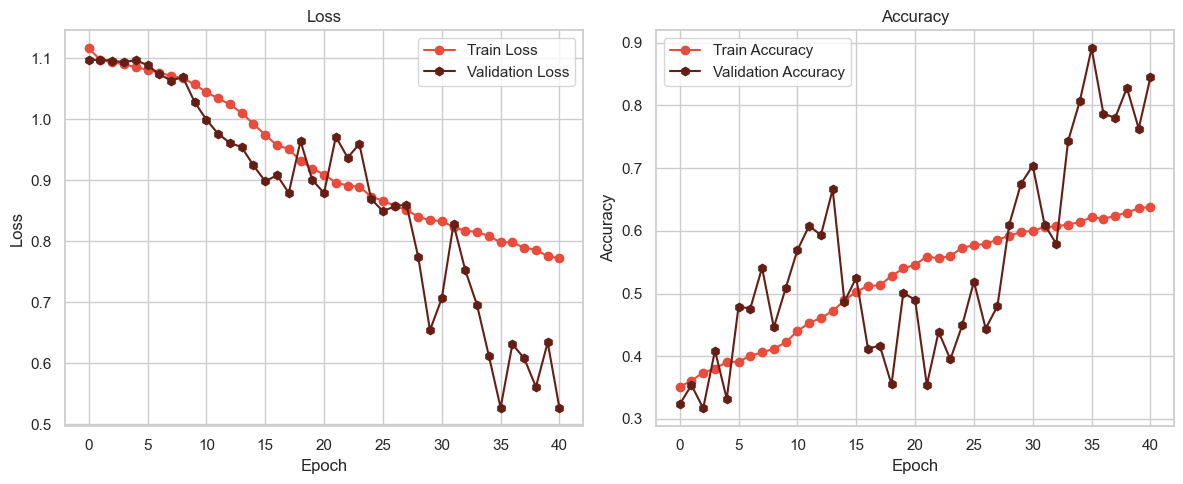

In [18]:
def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, save_path):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, color="#E74C3C", label='Train Loss', marker='o')
    plt.plot(val_losses, color="#641E15", label='Validation Loss', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, color="#E74C3C", label='Train Accuracy', marker='o')
    plt.plot(val_accuracies, color="#641E15", label='Validation Accuracy', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, f'plots/{exp_name}_accuracy_and_Loss.png')

## Confronto con ResNet e VGG

In [19]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
def train_model(model, train_loader, test_loader, device, num_epochs):
    # Define the loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_predictions / total_predictions

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    print('Finished Training')
    return model

def evaluate_model(model, data_loader, device, epochs):
    model.eval()  # Set the model to evaluation mode
    test_losses = []
    test_accuracies = []

    with torch.no_grad():  # Do not calculate gradients to save memory
        for epoch in range(epochs):
            running_loss = 0.0
            correct_predictions = 0
            total_predictions = 0

            for images, labels in data_loader:
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = loss_fn(outputs, labels)

                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_predictions += labels.size(0)

                running_loss += loss.item() * images.size(0)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_accuracy = correct_predictions / total_predictions

            test_losses.append(epoch_loss)
            test_accuracies.append(epoch_accuracy)

    return test_losses, test_accuracies

In [ ]:
def plot_comparison(model_name, rps_test_losses, rps_test_accuracies, model_test_losses, model_test_accuracies, save_path):
    epochs = range(1, len(rps_test_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, rps_test_losses, color="#641E15", label='RPS Test Loss', marker='o')
    plt.plot(epochs, model_test_losses, color="#3498DB", label=f'{model_name} Test Loss', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Test Loss Comparison')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, rps_test_accuracies, color="#641E15", label='RPS Test Accuracy', marker='o')
    plt.plot(epochs, model_test_accuracies, color="#3498DB", label=f'{model_name} Test Accuracy', marker='h')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Test Accuracy Comparison')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

In [ ]:
from torchvision import models

# Load ResNet 
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 3)  

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
resnet = resnet.to(device)

rps_test_losses = test_losses
rps_test_accuracies = test_accuracies

# Create DataLoader
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

resnet_test_dataset = CustomDataset(df_test, transform=resnet_transform)
resnet_test_loader = DataLoader(resnet_test_dataset, batch_size=64, shuffle=False)

# Evaluate ResNet and Plot comparison
resnet = train_model(resnet, train_loader, test_loader, device, num_epochs=50)
resnet_test_losses, resnet_test_accuracies = evaluate_model(resnet, resnet_test_loader, device, epochs=len(rps_test_losses))
plot_comparison('ResNet', rps_test_losses, rps_test_accuracies, resnet_test_losses, resnet_test_accuracies,'plots/Comparison_RPS_ResNet_Test_Performance.png')

In [ ]:
# Load VGG 
vgg = models.vgg16(weights=models.VGG16Weights.IMAGENET1K_V1)
num_ftrs = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(num_ftrs, 3)

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
vgg = vgg.to(device)

# Create DataLoader for VGG train and test set
vgg_train_dataset = CustomDataset(df_train, transform=resnet_transform) # use the same transform as ResNet
vgg_train_loader = DataLoader(vgg_train_dataset, batch_size=64, shuffle=True)

vgg_test_dataset = CustomDataset(df_test, transform=resnet_transform) # use the same transform as ResNet
vgg_test_loader = DataLoader(vgg_test_dataset, batch_size=64, shuffle=False)

# Evaluate VGG and Plot comparison
vgg = train_model(vgg, vgg_train_loader, vgg_test_loader, device, num_epochs=50)
vgg_test_losses, vgg_test_accuracies = evaluate_model(vgg, vgg_test_loader, device, epochs=len(rps_test_losses))
plot_comparison('VGG', rps_test_losses, rps_test_accuracies, vgg_test_losses, vgg_test_accuracies, 'plots/Comparison_RPS_VGG_Test_Performance.png')